# Network Intrusion Detection System using AI

Ce notebook construit un système de détection d'intrusion réseau à double couche :
- **Détection par signature** (Random Forest, SVM, k-NN, MLP)
- **Détection d'anomalies** (Isolation Forest)

Le dataset utilisé est UNSW-NB15.

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import logging
import warnings
import time
import winsound
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

# Supprimer les avertissements non nécessaires
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Création des dossiers pour les résultats
os.makedirs('figures/knn_improved', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Configure logging for the classifier class
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Création des dossiers pour les résultats
os.makedirs('figures/mlp', exist_ok=True)

## 2. Data Loading and Exploration

In [4]:
# Load the dataset
df = pd.read_csv("UNSW_NB15_training-set.csv")

# Display basic information
print("Dataset preview:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nClass distribution (label):")
print(df['label'].value_counts())
print("\nAttack categories (attack_cat):")
print(df['attack_cat'].value_counts())

Dataset preview:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2          

## 3. Data Visualization

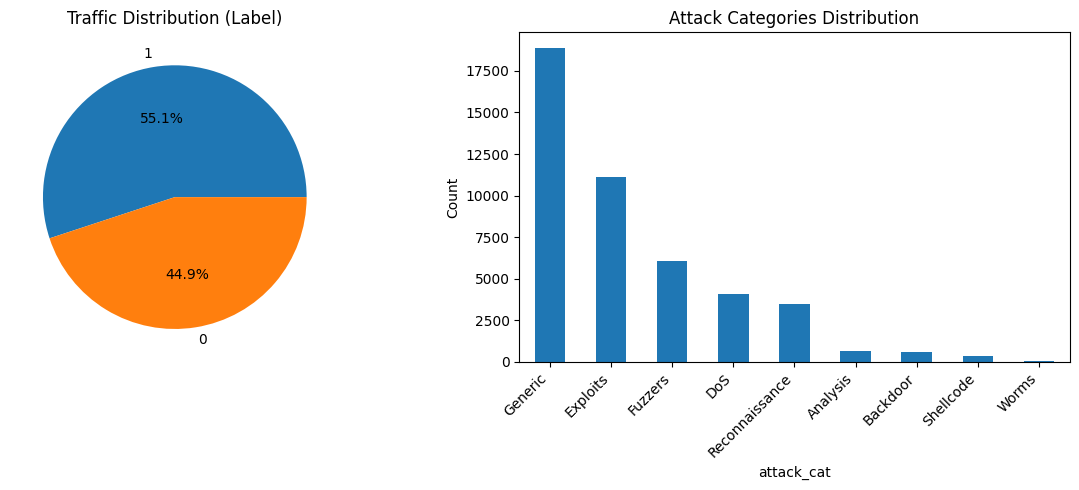

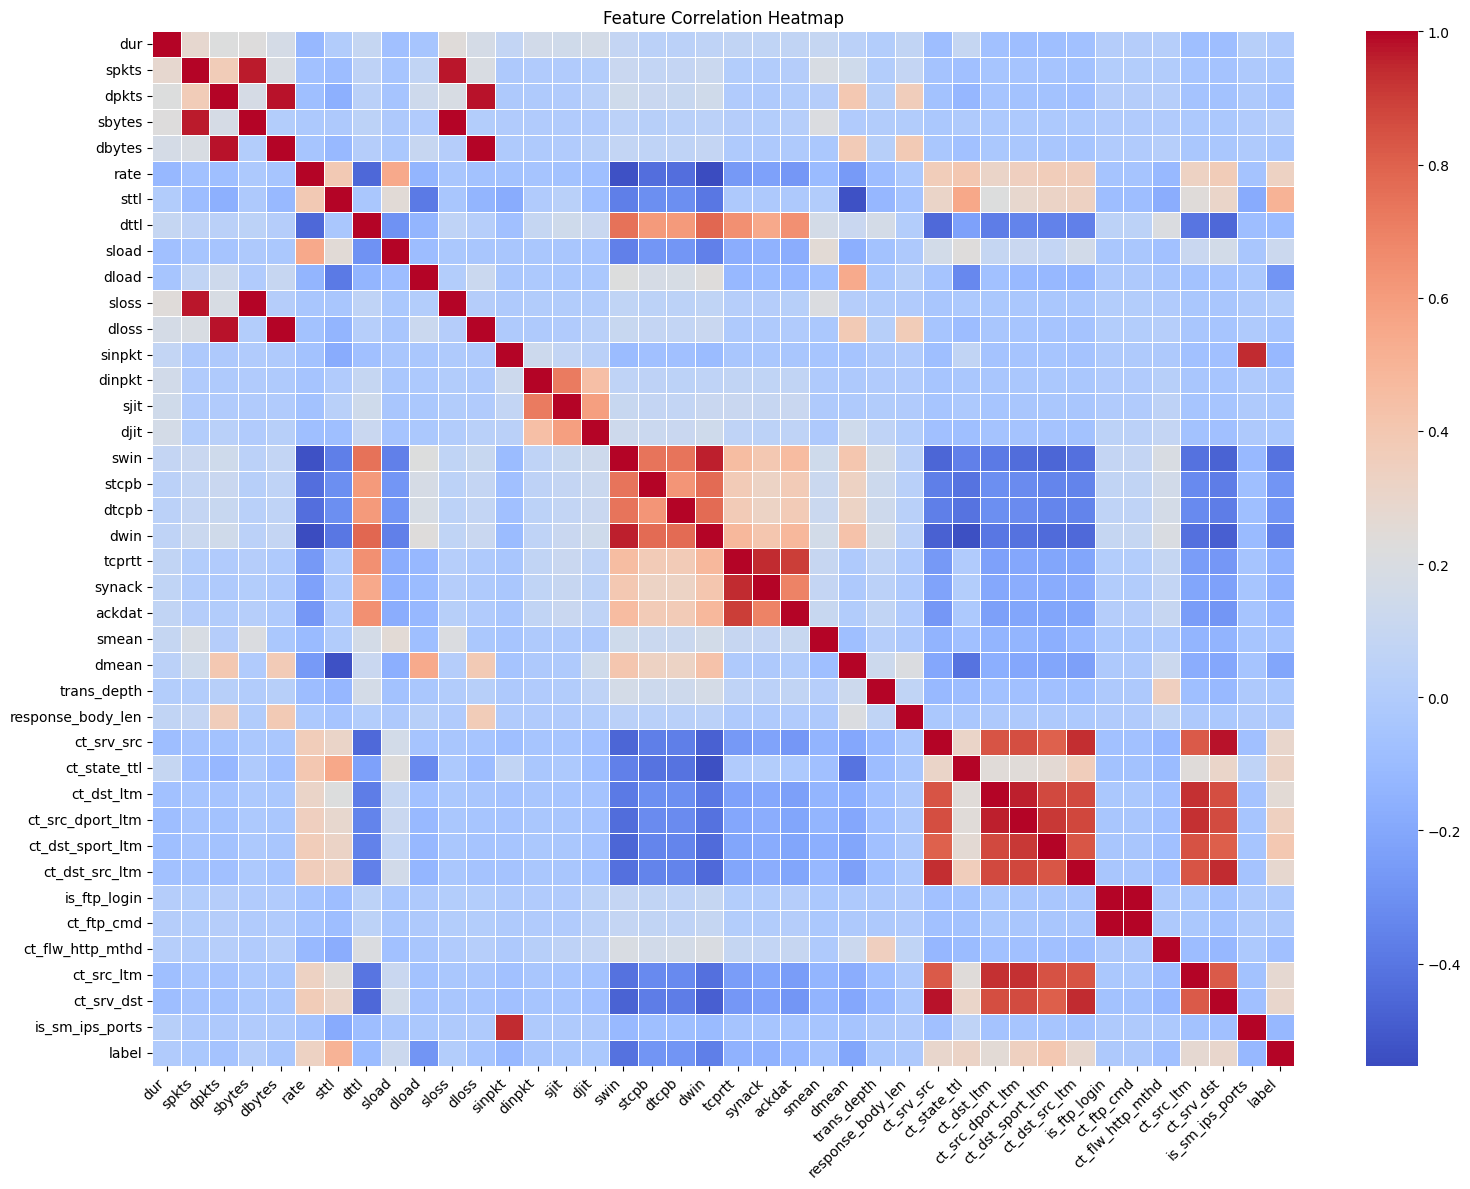

In [5]:
# Plot class distribution and attack categories
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1)
ax1.set_title('Traffic Distribution (Label)')
ax1.set_ylabel('')

ax2 = plt.subplot(1, 2, 2)
attack_data = df[df['label'] == 1]['attack_cat'].value_counts()
attack_data.plot(kind='bar', ax=ax2)
ax2.set_title('Attack Categories Distribution')
ax2.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlation heatmap of numeric features (excluding 'id')
plt.figure(figsize=(16, 12))
numeric_cols = df.select_dtypes(include=np.number).columns.drop('id', errors='ignore')
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Entraînement KNN 

### Explication de la Fonction `load_and_preprocess_data`

La fonction `load_and_preprocess_data` est conçue pour charger les données à partir d'un fichier CSV, les prétraiter et les diviser en ensembles d'entraînement, de validation et de test. Voici une explication détaillée de chaque étape :

1.  **Chargement des données :**
    *   La fonction prend en entrée le chemin du fichier CSV (`filepath`).
    *   Elle utilise `pd.read_csv` pour charger les données dans un DataFrame pandas.
    *   Des vérifications sont effectuées pour s'assurer que le fichier existe et que les colonnes obligatoires (`label`) sont présentes.

2.  **Suppression des colonnes non nécessaires :**
    *   Les colonnes `id` et `attack_cat` sont supprimées car elles ne sont pas nécessaires pour la classification binaire (Attaque/Normal).

3.  **Gestion des valeurs manquantes :**
    *   La fonction vérifie s'il y a des valeurs manquantes dans le DataFrame.
    *   Si des valeurs manquantes sont détectées, les lignes correspondantes sont supprimées.

4.  **Séparation des caractéristiques et des étiquettes :**
    *   La colonne `label` est séparée du reste des données pour créer les ensembles de caractéristiques (X) et d'étiquettes (y).

5.  **Encodage des caractéristiques catégorielles :**
    *   Les colonnes catégorielles (de type `object` ou `category`) sont encodées en utilisant `LabelEncoder`.
    *   Un `LabelEncoder` est créé pour chaque colonne catégorielle et stocké dans un dictionnaire (`label_encoders`) pour une utilisation ultérieure.

6.  **Mise à l'échelle des caractéristiques numériques :**
    *   Les caractéristiques numériques sont mises à l'échelle en utilisant `StandardScaler` pour avoir une moyenne de 0 et un écart type de 1.
    *   Le `StandardScaler` est stocké pour une utilisation ultérieure.

7.  **Division en ensembles d'entraînement, de validation et de test :**
    *   Les données sont divisées en ensembles d'entraînement (70%), de validation (15%) et de test (15%) en utilisant `train_test_split`.
    *   La stratification est utilisée pour s'assurer que la distribution des classes est la même dans chaque ensemble.

8.  **Retour des données prétraitées :**
    *   La fonction retourne les ensembles d'entraînement, de validation et de test, ainsi que le `StandardScaler` et les `LabelEncoder` utilisés pour le prétraitement.

In [6]:

def load_and_preprocess_data(filepath, test_size=0.2, val_size=0.15, random_state=42):
    """
    Charge et prétraite les données pour l'entraînement
    Args:
        filepath: Chemin du fichier CSV
        test_size: Proportion de l'ensemble de test
        val_size: Proportion de l'ensemble de validation
        random_state: Graine aléatoire pour la reproductibilité
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders
    """
    print(f"Chargement et prétraitement des données depuis {filepath}...")
    
    # Vérifier l'existence du fichier
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Le fichier {filepath} n'existe pas.")
    
    # Charger les données avec gestion d'erreurs
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        raise Exception(f"Erreur lors du chargement du fichier CSV: {str(e)}")
    
    print(f"Données chargées: {df.shape[0]} lignes et {df.shape[1]} colonnes")
    
    # Vérifier que les colonnes obligatoires sont présentes
    required_cols = ['label']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Colonnes requises manquantes. Assurez-vous que {required_cols} sont présentes.")
    
    # Supprimer les colonnes non nécessaires
    df_processed = df.drop(columns=['id', 'attack_cat'], errors='ignore')
    
    # Afficher les informations sur les valeurs manquantes
    missing_values = df_processed.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print(f"Valeurs manquantes détectées dans les colonnes suivantes:")
        for col, count in missing_cols.items():
            print(f"  - {col}: {count} valeurs manquantes ({(count/len(df_processed))*100:.2f}%)")
    
    # Gérer les valeurs manquantes - considérer l'imputation plutôt que la suppression
    rows_before = df_processed.shape[0]
    df_processed = df_processed.dropna()
    rows_after = df_processed.shape[0]
    if rows_before > rows_after:
        print(f"Suppression de {rows_before - rows_after} lignes avec des valeurs manquantes ({(rows_before - rows_after) / rows_before * 100:.2f}%)")
    
    # Séparer les caractéristiques et les étiquettes
    X = df_processed.drop(columns=['label'], errors='ignore')
    y = df_processed['label']  # 0 pour normal, 1 pour attaque
    
    # Vérifier la distribution des classes
    class_counts = y.value_counts()
    print(f"Distribution des classes:")
    for cls, count in class_counts.items():
        print(f"  - Classe {cls}: {count} échantillons ({count/len(y)*100:.2f}%)")
    
    # Encoder les caractéristiques catégorielles
    label_encoders = {}
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print(f"Encodage des {len(categorical_cols)} colonnes catégorielles:")
        for col in categorical_cols:
            unique_values = X[col].nunique()
            print(f"  - {col}: {unique_values} valeurs uniques")
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))  # Convertir en string pour éviter les erreurs
            label_encoders[col] = le
    
    # Mise à l'échelle des caractéristiques numériques
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Division en ensembles d'entraînement, validation et test avec stratification
    try:
        # D'abord, séparer les données de test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Ensuite, diviser les données restantes en ensembles d'entraînement et de validation
        val_ratio = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
        )
    except ValueError as e:
        # Si la stratification échoue (par exemple, trop peu d'échantillons dans une classe)
        print(f"Avertissement lors de la stratification: {str(e)}")
        print("Tentative de division sans stratification...")
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_ratio, random_state=random_state
        )
    
    print(f"Dimensions des ensembles de données:")
    print(f"  Train: X={X_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={X_val.shape}, y={y_val.shape}")
    print(f"  Test: X={X_test.shape}, y={y_test.shape}")
    
    # Vérifier les distributions des classes dans chaque ensemble
    print(f"Distribution des classes dans les ensembles:")
    print(f"  Train: {np.bincount(y_train.astype(int))}")
    print(f"  Validation: {np.bincount(y_val.astype(int))}")
    print(f"  Test: {np.bincount(y_test.astype(int))}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders


### Explication de la Fonction `optimize_knn_hyperparameters`

La fonction `optimize_knn_hyperparameters` est conçue pour optimiser les hyperparamètres d'un modèle KNN (K-Nearest Neighbors) en utilisant une recherche aléatoire sur une grille de paramètres prédéfinie. Voici une explication détaillée de chaque étape :

1.  **Définition de la grille de paramètres :**
    *   Un dictionnaire `param_grid` est défini, contenant les hyperparamètres à optimiser et les valeurs possibles pour chacun d'eux.
        *   `n_neighbors`: Nombre de voisins à considérer (3, 5, 7, 9, 11, 15).
        *   `weights`: Pondération des voisins (uniforme ou basée sur la distance).
        *   `metric`: Métrique de distance à utiliser (euclidienne ou de Manhattan).
        *   `algorithm`: Algorithme utilisé pour calculer les plus proches voisins ('auto', 'ball_tree', 'kd_tree').

2.  **Création du modèle KNN :**
    *   Un modèle KNN est créé en utilisant la classe `KNeighborsClassifier` de scikit-learn.

3.  **Recherche par grille avec validation croisée :**
    *   La fonction utilise `RandomizedSearchCV` pour trouver les meilleurs hyperparamètres.
        *   `knn`: Le modèle KNN à optimiser.
        *   `param_grid`: La grille de paramètres à explorer.
        *   `cv`: Le nombre de plis pour la validation croisée (par défaut 3).
        *   `scoring`: La métrique à utiliser pour évaluer les performances (accuracy).
        *   `n_jobs`: Le nombre de cœurs de CPU à utiliser en parallèle (-1 pour utiliser tous les cœurs disponibles).
        *   `verbose`: Niveau de verbosité (1 pour afficher des informations pendant la recherche).

4.  **Entraînement du modèle :**
    *   La fonction entraîne le modèle en utilisant la méthode `fit` de `RandomizedSearchCV`.
    *   Le temps d'entraînement est mesuré pour évaluer l'efficacité de la recherche.

5.  **Évaluation sur l'ensemble de validation :**
    *   Une fois la recherche terminée, le modèle est évalué sur l'ensemble de validation en utilisant la méthode `predict` pour obtenir les prédictions, puis en calculant l'accuracy avec `accuracy_score`.

6.  **Affichage des résultats :**
    *   Les meilleurs hyperparamètres trouvés sont affichés, ainsi que le score de validation croisée et le score sur l'ensemble de validation.
    *   Les 3 meilleures combinaisons de paramètres sont également affichées, avec leurs scores moyens et écarts-types.

7.  **Gestion des erreurs :**
    *   Si une erreur se produit pendant l'optimisation, la fonction utilise des paramètres par défaut pour créer et entraîner un modèle KNN.

8.  **Retour des résultats :**
    *   La fonction retourne les meilleurs hyperparamètres trouvés et le score de validation.


In [7]:

def optimize_knn_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparamètres du modèle KNN
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        cv: Nombre de plis pour la validation croisée
    Returns:
        Meilleurs hyperparamètres et score
    """
    print(f"Optimisation des hyperparamètres KNN...")
    
    # Définir une grille de paramètres plus efficace
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
    
    # Créer le modèle KNN
    knn = KNeighborsClassifier()
    
    # Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
    print(f"Lancement de la recherche par grille avec {cv} plis...")
    grid_search = RandomizedSearchCV(
        knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )
    
    try:
        # Entraîner le modèle avec gestion du temps
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        search_time = time.time() - start_time
        print(f"Recherche par grille terminée en {search_time:.2f} secondes")
        
        # Évaluer sur l'ensemble de validation
        val_score = accuracy_score(y_val, grid_search.predict(X_val))
        print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")
        print(f"Score de validation croisée: {grid_search.best_score_:.4f}")
        print(f"Score sur l'ensemble de validation: {val_score:.4f}")
        
        # Afficher les 3 meilleures combinaisons de paramètres
        results = grid_search.cv_results_
        sorted_idx = np.argsort(results['mean_test_score'])[::-1]
        print("\nTop 3 des meilleures combinaisons de paramètres:")
        for i in range(min(3, len(sorted_idx))):
            idx = sorted_idx[i]
            print(f"Rang {i+1}: {results['params'][idx]}")
            print(f"  Score moyen: {results['mean_test_score'][idx]:.4f}")
            print(f"  Écart-type: {results['std_test_score'][idx]:.4f}")
        
        return grid_search.best_params_, val_score
    
    except Exception as e:
        print(f"Erreur lors de l'optimisation des hyperparamètres: {str(e)}")
        # Paramètres par défaut en cas d'erreur
        default_params = {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}
        print(f"Utilisation des paramètres par défaut: {default_params}")
        model = KNeighborsClassifier(**default_params)
        model.fit(X_train, y_train)
        val_score = accuracy_score(y_val, model.predict(X_val))
        return default_params, val_score


### Explication de la Fonction `plot_learning_curve`

La fonction `plot_learning_curve` est conçue pour évaluer l'impact de la taille de l'ensemble d'entraînement sur les performances du modèle KNN. Elle utilise la fonction `learning_curve` de scikit-learn pour générer des courbes d'apprentissage qui montrent comment l'accuracy du modèle évolue en fonction de la taille de l'ensemble d'entraînement. Voici une explication détaillée de chaque étape :

1.  **Préparation du graphique :**
    *   La fonction prend en entrée un estimateur (le modèle KNN), les caractéristiques (X), les étiquettes (y), le nombre de plis pour la validation croisée (cv), le nombre de jobs pour le calcul parallèle (n\_jobs) et les tailles relatives de l'ensemble d'entraînement à évaluer (train\_sizes).
    *   Elle crée une figure matplotlib pour afficher les courbes d'apprentissage.

2.  **Génération des courbes d'apprentissage :**
    *   La fonction utilise la fonction `learning_curve` de scikit-learn pour générer les courbes d'apprentissage.
        *   `estimator`: Le modèle à évaluer.
        *   `X`: Les caractéristiques.
        *   `y`: Les étiquettes.
        *   `train_sizes`: Les tailles relatives de l'ensemble d'entraînement à évaluer.
        *   `cv`: Le nombre de plis pour la validation croisée.
        *   `n_jobs`: Le nombre de jobs pour le calcul parallèle.
        *   `scoring`: La métrique à utiliser pour évaluer les performances (accuracy).
        *   `shuffle`: Mélanger les données avant de les diviser en plis.
        *   `random_state`: Graine aléatoire pour la reproductibilité.
    *   La fonction `learning_curve` retourne les tailles de l'ensemble d'entraînement, les scores d'entraînement et les scores de validation.

3.  **Calcul des moyennes et écarts-types :**
    *   La fonction calcule les moyennes et les écarts-types des scores d'entraînement et de validation pour chaque taille d'ensemble d'entraînement.

4.  **Traçage des courbes d'apprentissage :**
    *   La fonction trace les courbes d'apprentissage en utilisant les moyennes et les écarts-types calculés.
    *   Elle utilise des couleurs et des styles différents pour les courbes d'entraînement et de validation.
    *   Elle ajoute une zone ombrée autour de chaque courbe pour représenter l'écart-type.

5.  **Amélioration de l'aspect du graphique :**
    *   La fonction ajoute un titre, des étiquettes d'axe, une grille et une légende au graphique.
    *   Elle utilise des polices de caractères plus grandes et plus grasses pour améliorer la lisibilité.
    *   Elle ajuste la disposition du graphique pour éviter les chevauchements.

6.  **Ajout d'informations importantes :**
    *   La fonction ajoute une annotation pour indiquer la taille de l'ensemble d'entraînement qui donne la meilleure accuracy de validation.

7.  **Sauvegarde du graphique :**
    *   La fonction sauvegarde le graphique dans un fichier PNG.

8.  **Gestion des erreurs :**
    *   Si une erreur se produit pendant le traçage des courbes d'apprentissage, la fonction affiche un message d'erreur et ferme la figure.



In [8]:

def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Trace la courbe d'apprentissage pour évaluer l'impact de la taille de l'ensemble d'entraînement
    Args:
        estimator: Le modèle à évaluer
        X: Caractéristiques
        y: Étiquettes
        cv: Nombre de plis pour la validation croisée
        n_jobs: Nombre de jobs pour le calcul parallèle
        train_sizes: Tailles relatives de l'ensemble d'entraînement à évaluer
    """
    print("Traçage de la courbe d'apprentissage...")
    plt.figure(figsize=(10, 6))
    
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs,
            scoring='accuracy', shuffle=True, random_state=42
        )
        
        # Calculer les moyennes et écarts-types
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Tracer les courbes d'apprentissage avec un style amélioré
        plt.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Entraînement', linewidth=2)
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#1f77b4')
        plt.plot(train_sizes, val_mean, 'o-', color='#ff7f0e', label='Validation', linewidth=2)
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#ff7f0e')
        
        # Améliorer l'aspect du graphique
        plt.title('Courbe d\'apprentissage KNN', fontsize=14, fontweight='bold')
        plt.xlabel('Taille de l\'ensemble d\'entraînement', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='lower right', fontsize=12)
        plt.tight_layout()
        
        # Ajouter des informations importantes
        max_val_mean = np.max(val_mean)
        max_val_idx = np.argmax(val_mean)
        max_val_size = train_sizes[max_val_idx]
        plt.annotate(f'Maximum: {max_val_mean:.4f}',
                    xy=(max_val_size, max_val_mean),
                    xytext=(max_val_size, max_val_mean - 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                    fontsize=10, ha='center')
        
        plt.savefig('figures/knn_improved/knn_learning_curve.png', dpi=300, bbox_inches='tight')
        print("✅ Courbe d'apprentissage enregistrée dans figures/knn_improved/knn_learning_curve.png")
        
    except Exception as e:
        print(f"Erreur lors du traçage de la courbe d'apprentissage: {str(e)}")
        plt.close()




### Explication de la Fonction `plot_training_metrics`

La fonction `plot_training_metrics` est conçue pour visualiser les métriques d'entraînement et de validation au fil des époques lors de l'entraînement d'un modèle KNN. Elle prend en entrée les listes des accuracies, losses, F1-scores et recalls pour les ensembles d'entraînement et de validation, ainsi que le nombre total d'époques. Voici une explication détaillée de chaque étape :

1.  **Configuration de la figure :**
    *   La fonction crée une figure avec quatre sous-graphiques disposés en une grille 2x2. Chaque sous-graphique affichera une métrique différente (accuracy, loss, F1-score, recall).
    *   La taille de la figure est définie pour une meilleure lisibilité.

2.  **Style commun pour les graphiques :**
    *   Une boucle est utilisée pour appliquer un style commun à tous les sous-graphiques :
        *   Ajout d'une grille en arrière-plan pour faciliter la lecture des valeurs.
        *   Placement de la grille derrière les données pour ne pas obstruer les courbes.

3.  **Traçage des métriques :**
    *   Pour chaque métrique (accuracy, loss, F1-score, recall) :
        *   Les valeurs d'entraînement et de validation sont tracées en fonction du nombre d'époques.
        *   Des couleurs et des étiquettes différentes sont utilisées pour distinguer les courbes d'entraînement et de validation.
        *   Un titre est ajouté pour identifier la métrique affichée.
        *   Des étiquettes sont ajoutées pour les axes x et y.
        *   Une légende est ajoutée pour identifier les courbes.

4.  **Amélioration de la lisibilité :**
    *   La fonction utilise des polices de caractères plus grandes et plus grasses pour améliorer la lisibilité des titres et des étiquettes.
    *   Elle ajuste la disposition des sous-graphiques pour éviter les chevauchements.

5.  **Sauvegarde de la figure :**
    *   La figure est sauvegardée dans un fichier PNG.

6.  **Retour de la figure :**
    *   La fonction retourne la figure matplotlib créée, ce qui permet de la manipuler ou de la fermer ultérieurement si nécessaire.


In [9]:
def plot_training_metrics(
     train_accuracies, val_accuracies, train_losses, val_losses,
     train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
     algorithm_name="XGBoost", output_dir="figures/xgb"):
     """
     Fonction dédiée pour tracer les métriques d'entraînement et enregistrer chaque graphe dans un fichier séparé.
     Args:
          train_accuracies: Liste des accuracies d'entraînement
          val_accuracies: Liste des accuracies de validation
          train_losses: Liste des pertes d'entraînement
          val_losses: Liste des pertes de validation
          train_f1s: Liste des F1 scores d'entraînement
          val_f1s: Liste des F1 scores de validation
          train_recalls: Liste des recalls d'entraînement
          val_recalls: Liste des recalls de validation
          n_epochs: Nombre d'époques
          algorithm_name: Nom de l'algorithme pour les titres (défaut: "XGBoost")
          output_dir: Répertoire de sortie pour les figures (défaut: "figures/xgb")
     Returns:
          None
     """
     # Style commun pour tous les graphiques
     metrics = {
          'Accuracy': (train_accuracies, val_accuracies),
          'Loss': (train_losses, val_losses),
          'F1 Score': (train_f1s, val_f1s),
          'Recall': (train_recalls, val_recalls)
     }

     for metric_name, (train_metric, val_metric) in metrics.items():
          fig, ax = plt.subplots(figsize=(10, 6))
          ax.grid(True, linestyle='--', alpha=0.7)
          ax.set_axisbelow(True)  # Placer la grille derrière les données

          # Graphique de la métrique
          ax.plot(range(1, n_epochs + 1), train_metric, '-o', label='Entraînement', color='#1f77b4',
                    linewidth=2, markersize=5, alpha=0.8)
          ax.plot(range(1, n_epochs + 1), val_metric, '-o', label='Validation', color='#ff7f0e',
                    linewidth=2, markersize=5, alpha=0.8)
          ax.set_title(f'{algorithm_name} - {metric_name}', fontsize=16, fontweight='bold')
          ax.set_xlabel('Époque', fontsize=14)
          ax.set_ylabel(metric_name, fontsize=14)
          ax.legend(fontsize=12)

          # Ajouter des annotations pour les valeurs maximales (validation)
          max_val_metric = max(val_metric)
          max_val_metric_idx = val_metric.index(max_val_metric)
          ax.annotate(f'Max: {max_val_metric:.4f}',
                         xy=(max_val_metric_idx + 1, max_val_metric),
                         xytext=(max_val_metric_idx + 1, max_val_metric - 0.05),
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         fontsize=12, ha='center')

          plt.tight_layout()

          # Assurer que le répertoire de sortie existe
          os.makedirs(output_dir, exist_ok=True)
          output_path = os.path.join(output_dir, f'{algorithm_name.lower()}_{metric_name.lower().replace(" ", "_")}.png')
          plt.savefig(output_path, dpi=300, bbox_inches='tight')
          print(f"✅ Métriques d'entraînement enregistrées dans {output_path}")
          plt.close(fig)


### Explication de la Fonction `train_knn_progressive`

La fonction `train_knn_progressive` est conçue pour entraîner un modèle KNN de manière progressive, en augmentant graduellement la taille de l'ensemble d'entraînement à chaque époque. Cette approche permet d'observer l'évolution des performances du modèle en fonction de la quantité de données utilisées pour l'entraînement. Voici une explication détaillée de chaque étape :

1.  **Initialisation :**
    *   La fonction prend en entrée les ensembles d'entraînement (X\_train, y\_train), de validation (X\_val, y\_val) et de test (X\_test, y\_test), les meilleurs hyperparamètres trouvés lors de l'optimisation (best\_params) et le nombre d'époques d'entraînement (n\_epochs).
    *   Elle initialise des listes pour stocker les métriques d'entraînement et de validation à chaque époque (accuracy, loss, precision, recall, f1-score).
    *   Elle initialise également des variables pour suivre le meilleur modèle (celui qui obtient la meilleure accuracy sur l'ensemble de validation).

2.  **Boucle d'entraînement :**
    *   La fonction effectue une boucle sur le nombre d'époques spécifié.
    *   À chaque époque, elle augmente progressivement la taille de l'ensemble d'entraînement en utilisant un ratio qui varie de train\_ratio\_start à train\_ratio\_end.
    *   Elle sélectionne un sous-ensemble aléatoire de l'ensemble d'entraînement en utilisant ce ratio.
    *   Elle crée un modèle KNN avec les meilleurs hyperparamètres trouvés et l'entraîne sur le sous-ensemble sélectionné.
    *   Elle évalue les performances du modèle sur les ensembles d'entraînement et de validation en calculant l'accuracy, la loss, la precision, le recall et le f1-score.
    *   Elle met à jour le meilleur modèle si les performances sur l'ensemble de validation sont meilleures que celles du meilleur modèle précédent.

3.  **Évaluation finale :**
    *   Une fois la boucle d'entraînement terminée, la fonction évalue les performances du meilleur modèle sur l'ensemble de test en calculant l'accuracy, la precision, le recall et le f1-score.
    *   Elle calcule également la matrice de confusion pour analyser les erreurs de classification du modèle.

4.  **Traçage des courbes d'apprentissage :**
    *   La fonction trace les courbes d'apprentissage pour visualiser l'évolution des métriques d'entraînement et de validation au fil des époques.
    *   Elle trace également la matrice de confusion pour visualiser les performances du modèle sur l'ensemble de test.

5.  **Retour des résultats :**
    *   La fonction retourne un dictionnaire contenant les informations d'apprentissage (métriques d'entraînement et de validation, courbes d'apprentissage) et le meilleur modèle.

In [10]:

def train_knn_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=50):
    """
    Entraîne le modèle KNN de manière progressive en augmentant la taille de l'ensemble d'entraînement
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        X_test: Caractéristiques de test
        y_test: Étiquettes de test
        best_params: Meilleurs hyperparamètres trouvés
        n_epochs: Nombre d'époques d'entraînement
    Returns:
        Historique des métriques et meilleur modèle
    """
    print(f"Entraînement progressif du KNN sur {n_epochs} époques...")
    
    # Convertir en tableaux NumPy pour éviter les problèmes d'indexation
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
        
    # Vérifier si l'entraînement est possible
    if len(X_train) == 0 or len(y_train) == 0:
        raise ValueError("Ensembles d'entraînement vides")
    
    if len(np.unique(y_train)) < 2:
        raise ValueError("L'ensemble d'entraînement doit contenir au moins deux classes différentes")
    
    # Listes pour stocker les métriques
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    epoch_train_sizes = []
    
    # Meilleur modèle
    best_model = None
    best_val_acc = 0
    
    # Valeurs pour l'augmentation progressive de la taille de l'ensemble d'entraînement
    train_ratio_start = 0.2  # Commence avec 20% des données
    train_ratio_end = 1.0    # Termine avec 100% des données
    
    # Assurer une répartition équilibrée des classes lors de l'échantillonnage
    class_indices = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        class_indices[cls] = np.where(y_train == cls)[0]
    
    # Barre de progression
    with tqdm(total=n_epochs, desc="Entraînement") as pbar:
        for epoch in range(n_epochs):
            try:
                # Augmentation progressive de la taille de l'entraînement
                train_ratio = train_ratio_start + (train_ratio_end - train_ratio_start) * (epoch / max(1, n_epochs-1))
                
                # Sélectionner un échantillon stratifié
                indices = []
                for cls in unique_classes:
                    cls_indices = class_indices[cls]
                    # Calculer le nombre d'échantillons à prendre pour cette classe
                    n_samples = int(len(cls_indices) * train_ratio)
                    if n_samples > 0:
                        # Prendre un échantillon aléatoire de cette classe
                        cls_sample_indices = np.random.choice(cls_indices, n_samples, replace=False)
                        indices.extend(cls_sample_indices)
                
                # Mélanger les indices
                np.random.shuffle(indices)
                train_size = len(indices)
                epoch_train_sizes.append(train_size)
                
                # Extraire les données d'entraînement pour cette époque
                X_train_epoch = X_train[indices]
                y_train_epoch = y_train[indices]
                
                # Créer et entraîner le modèle avec les meilleurs hyperparamètres
                model = KNeighborsClassifier(**best_params)
                model.fit(X_train_epoch, y_train_epoch)
                
                # Évaluation sur l'ensemble d'entraînement
                train_preds = model.predict(X_train_epoch)
                train_acc = accuracy_score(y_train_epoch, train_preds)
                train_prec = precision_score(y_train_epoch, train_preds, zero_division=0)
                train_rec = recall_score(y_train_epoch, train_preds, zero_division=0)
                train_f1 = f1_score(y_train_epoch, train_preds, zero_division=0)
                train_accuracies.append(train_acc)
                train_precisions.append(train_prec)
                train_recalls.append(train_rec)
                train_f1s.append(train_f1)
                
                # Évaluation sur l'ensemble de validation
                val_preds = model.predict(X_val)
                val_acc = accuracy_score(y_val, val_preds)
                val_prec = precision_score(y_val, val_preds, zero_division=0)
                val_rec = recall_score(y_val, val_preds, zero_division=0)
                val_f1 = f1_score(y_val, val_preds, zero_division=0)
                val_accuracies.append(val_acc)
                val_precisions.append(val_prec)
                val_recalls.append(val_rec)
                val_f1s.append(val_f1)
                
                # Calcul des pertes (log loss) si predict_proba est disponible
                if hasattr(model, 'predict_proba'):
                    try:
                        train_probs = model.predict_proba(X_train_epoch)
                        val_probs = model.predict_proba(X_val)
                        
                        # Vérifier la validité des probabilités
                        if not np.any(np.isnan(train_probs)) and not np.any(np.isnan(val_probs)):
                            train_loss = log_loss(y_train_epoch, train_probs)
                            val_loss = log_loss(y_val, val_probs)
                        else:
                            train_loss = -np.log(max(0.001, train_acc))
                            val_loss = -np.log(max(0.001, val_acc))
                    except Exception:
                        # En cas d'erreur, utiliser une approximation
                        train_loss = -np.log(max(0.001, train_acc))
                        val_loss = -np.log(max(0.001, val_acc))
                else:
                    # Si predict_proba n'est pas disponible, simuler une relation inverse avec l'accuracy
                    train_loss = -np.log(max(0.001, train_acc))
                    val_loss = -np.log(max(0.001, val_acc))
                    
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                # Suivre le meilleur modèle
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model
                
                # Mettre à jour la barre de progression
                pbar.update(1)
                pbar.set_postfix({
                    'Train Acc': f'{train_acc:.4f}',
                    'Val Acc': f'{val_acc:.4f}',
                    'Train Size': train_size
                })
            
            except Exception as e:
                print(f"\nErreur à l'époque {epoch+1}: {str(e)}")
                continue
    
    # Si aucun modèle valide n'a été trouvé, utiliser un modèle par défaut
    if best_model is None:
        print("Aucun modèle valide trouvé pendant l'entraînement. Création d'un modèle par défaut.")
        best_model = KNeighborsClassifier(**best_params)
        best_model.fit(X_train, y_train)
    
    # Évaluation finale du meilleur modèle sur l'ensemble de test
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_test, test_pred)
    
    # Tracer les courbes d'apprentissage
    try:
        plot_training_metrics(train_accuracies, val_accuracies, train_losses, val_losses, 
                             train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
                             algorithm_name="KNN", output_dir="figures/knn_improved"
                             )
        
        # Graphique de la taille de l'ensemble d'entraînement
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_epochs+1), epoch_train_sizes, '-o', linewidth=2, markersize=4, color='#2ca02c')
        plt.title('Progression de la taille de l\'ensemble d\'entraînement', fontsize=14, fontweight='bold')
        plt.xlabel('Époque', fontsize=12)
        plt.ylabel('Nombre d\'échantillons', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('figures/knn_improved/knn_training_size.png', dpi=300)
        
        # Tracer la matrice de confusion pour le meilleur modèle
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
        plt.title('Matrice de confusion (Ensemble de test)', fontsize=14, fontweight='bold')
        plt.xlabel('Classe prédite', fontsize=12)
        plt.ylabel('Classe réelle', fontsize=12)
        plt.tight_layout()
        plt.savefig('figures/knn_improved/knn_confusion_matrix.png', dpi=300)
    except Exception as e:
        print(f"Erreur lors de la création des graphiques: {str(e)}")
    
    # Afficher les résultats finaux
    print("\n=== Résultats finaux ===")
    print(f"Accuracy sur l'ensemble de test: {test_accuracy:.4f}")
    print(f"Precision sur l'ensemble de test: {test_precision:.4f}")
    print(f"Recall sur l'ensemble de test: {test_recall:.4f}")
    print(f"F1-Score sur l'ensemble de test: {test_f1:.4f}")
    
    # Ajouter une fonction de classification des prédictions (par ex. pour calculer les taux de faux positifs/négatifs)
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    print(f"\nDétail de la matrice de confusion:")
    print(f"  - Vrais Négatifs (TN): {tn} ({tn/total*100:.2f}%)")
    print(f"  - Faux Positifs (FP): {fp} ({fp/total*100:.2f}%)")
    print(f"  - Faux Négatifs (FN): {fn} ({fn/total*100:.2f}%)")
    print(f"  - Vrais Positifs (TP): {tp} ({tp/total*100:.2f}%)")
    print(f"  - Taux de faux positifs: {fp/(fp+tn)*100:.2f}%")
    print(f"  - Taux de faux négatifs: {fn/(fn+tp)*100:.2f}%")
    
    # Retourner les informations d'apprentissage et le meilleur modèle
    return {
        'model': best_model,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'epoch_train_sizes': epoch_train_sizes,
        'best_val_accuracy': best_val_acc,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': conf_matrix
    }


In [11]:

def main(data_path="UNSW_NB15_training-set.csv", test_size=0.2, val_size=0.15, n_epochs=50, random_state=42):
    """
    Fonction principale qui exécute tout le pipeline
    """
    start_time = time.time()
    
    try:
        # Charger et prétraiter les données
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders = load_and_preprocess_data(
            filepath=data_path, test_size=test_size, val_size=val_size, random_state=random_state
        )
        
        # Sauvegarder le scaler et les encodeurs
        try:
            joblib.dump(scaler, "models/scaler.pkl")
            joblib.dump(label_encoders, "models/label_encoders.pkl")
            print("✅ Scaler et encodeurs sauvegardés dans le dossier 'models/'")
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du scaler et des encodeurs: {str(e)}")
        
        # Optimiser les hyperparamètres
        best_params, val_score = optimize_knn_hyperparameters(X_train, y_train, X_val, y_val)
        
        # Tracer la courbe d'apprentissage pour évaluer l'impact de la taille de l'ensemble d'entraînement
        model = KNeighborsClassifier(**best_params)
        plot_learning_curve(model, X_train, y_train)
        
        # Entraînement progressif
        results = train_knn_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=n_epochs)
        
        # Sauvegarder le meilleur modèle
        try:
            joblib.dump(results['model'], "models/KNN_best.pkl")
            print("✅ Meilleur modèle KNN sauvegardé dans models/KNN_best.pkl")
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du modèle: {str(e)}")
        
        # Affichage du temps total d'exécution
        elapsed_time = time.time() - start_time
        print(f"\nTemps total d'exécution: {elapsed_time:.2f} secondes ({elapsed_time/60:.2f} minutes)")
        
        # Résumé des performances
        print(f"\n📊 Résumé des performances:")
        print(f"  - Accuracy finale sur le test: {results['test_accuracy']:.4f}")
        print(f"  - Precision finale sur le test: {results['test_precision']:.4f}")
        print(f"  - Recall final sur le test: {results['test_recall']:.4f}")
        print(f"  - F1-Score final sur le test: {results['test_f1']:.4f}")
        print(f"  - Meilleure accuracy de validation: {results['best_val_accuracy']:.4f}")
        print(f"  - Meilleurs hyperparamètres: {best_params}")
        
        # Évaluation finale du modèle
        print("\n🔍 Analyse de la matrice de confusion:")
        conf_matrix = results['confusion_matrix']
        tn, fp, fn, tp = conf_matrix.ravel()
        print(f"  - Vrais Négatifs (Normal correctement identifié): {tn}")
        print(f"  - Faux Positifs (Normal classé comme Attaque): {fp}")
        print(f"  - Faux Négatifs (Attaque classée comme Normale): {fn}")
        print(f"  - Vrais Positifs (Attaque correctement identifiée): {tp}")
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"  - Spécificité (Taux de vrais négatifs): {specificity:.4f}")
        
        winsound.Beep(1000, 500)  # Bip de 1 seconde à 1000 Hz
        return results
    
    except Exception as e:
        print(f"\n❌ Erreur lors de l'exécution du pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


Pipeline d'analyse et d'entraînement KNN pour la détection d'intrusion réseau
Chargement et prétraitement des données depuis UNSW_NB15_training-set.csv...
Données chargées: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 échantillons (55.06%)
  - Classe 0: 37000 échantillons (44.94%)
Encodage des 3 colonnes catégorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de données:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
✅ Scaler et encodeurs sauvegardés dans le dossier 'models/'
Optimisation des hyperparamètres KNN...
Lancement de la recherche par grille avec 3 plis...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Recherche par grille terminée en 257.43 secondes
Meilleurs hyperparamètres: {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Score de validation croisée: 0.9413
Score sur l'ensemble de validation: 0.9440

Top 3 des meilleures combinaisons de paramètres:
Rang 1: {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
  Score moyen: 0.9413
  Écart-type: 0.0001
Rang 2: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan', 'algorithm': 'auto'}
  Score moyen: 0.9384
  Écart-type: 0.0008
Rang 3: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
  Score moyen: 0.9378
  Écart-type: 0.0011
Traçage de la courbe d'apprentissage...
✅ Courbe d'apprentissage enregistrée dans figures/knn_improved/knn_learning_curve.png
Entraînement progressif du KNN sur 25 époques...


Entraînement: 100%|██████████| 25/25 [39:46<00:00, 95.48s/it, Train Acc=1.0000, Val Acc=0.9440, Train Size=53515] 


✅ Métriques d'entraînement enregistrées dans figures/knn_improved\knn_accuracy.png
✅ Métriques d'entraînement enregistrées dans figures/knn_improved\knn_loss.png
✅ Métriques d'entraînement enregistrées dans figures/knn_improved\knn_f1_score.png
✅ Métriques d'entraînement enregistrées dans figures/knn_improved\knn_recall.png

=== Résultats finaux ===
Accuracy sur l'ensemble de test: 0.9444
Precision sur l'ensemble de test: 0.9718
Recall sur l'ensemble de test: 0.9260
F1-Score sur l'ensemble de test: 0.9483

Détail de la matrice de confusion:
  - Vrais Négatifs (TN): 7156 (43.46%)
  - Faux Positifs (FP): 244 (1.48%)
  - Faux Négatifs (FN): 671 (4.07%)
  - Vrais Positifs (TP): 8396 (50.99%)
  - Taux de faux positifs: 3.30%
  - Taux de faux négatifs: 7.40%
✅ Meilleur modèle KNN sauvegardé dans models/KNN_best.pkl

Temps total d'exécution: 3141.14 secondes (52.35 minutes)

📊 Résumé des performances:
  - Accuracy finale sur le test: 0.9444
  - Precision finale sur le test: 0.9718
  - Recall 

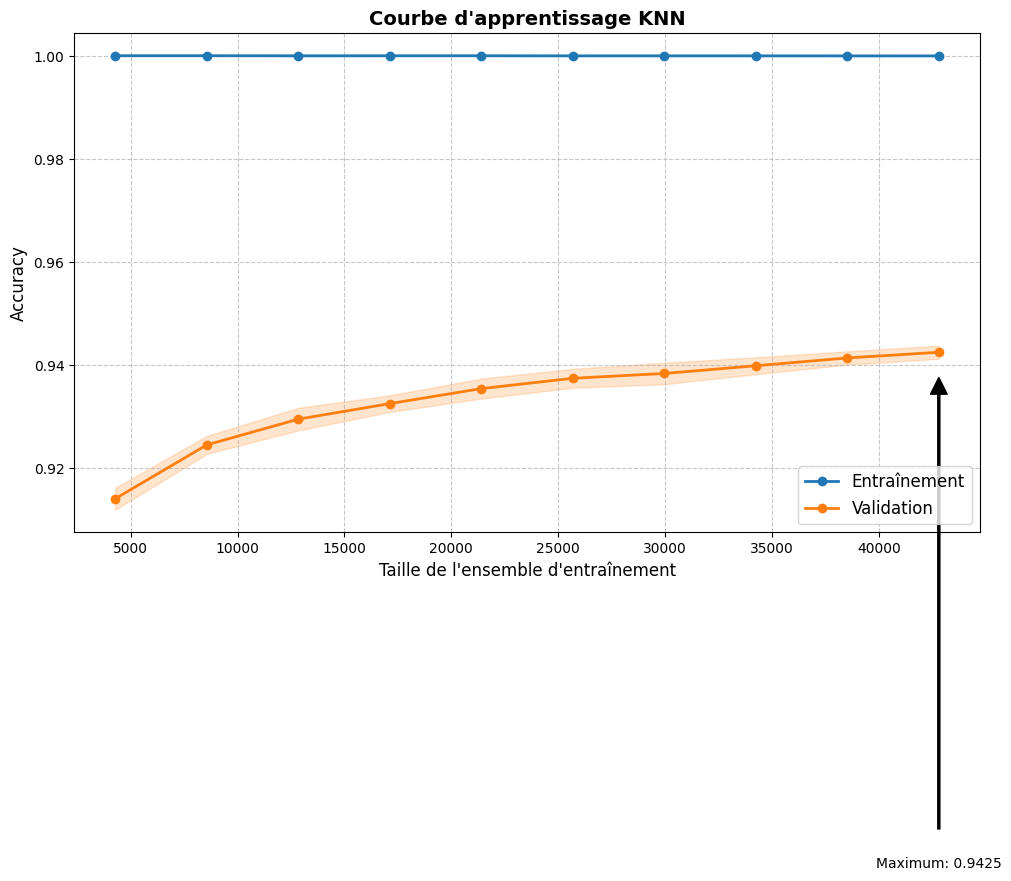

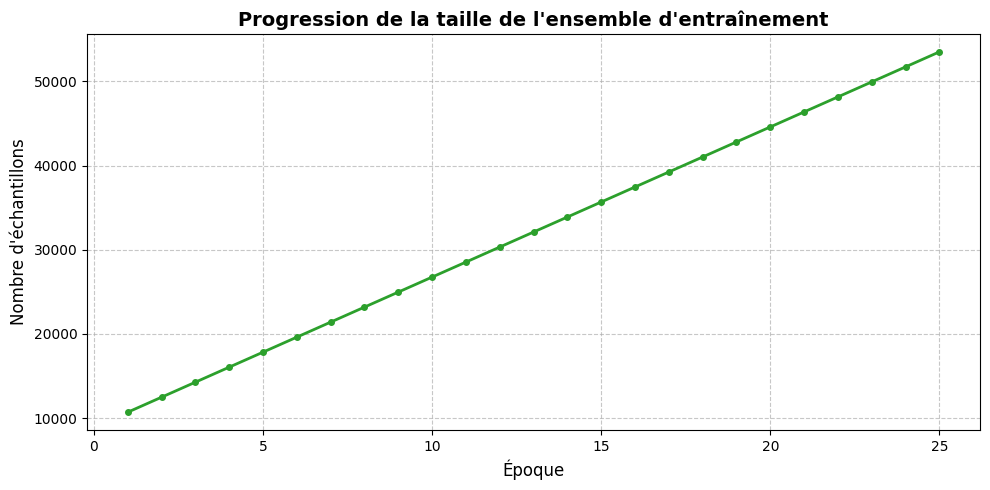

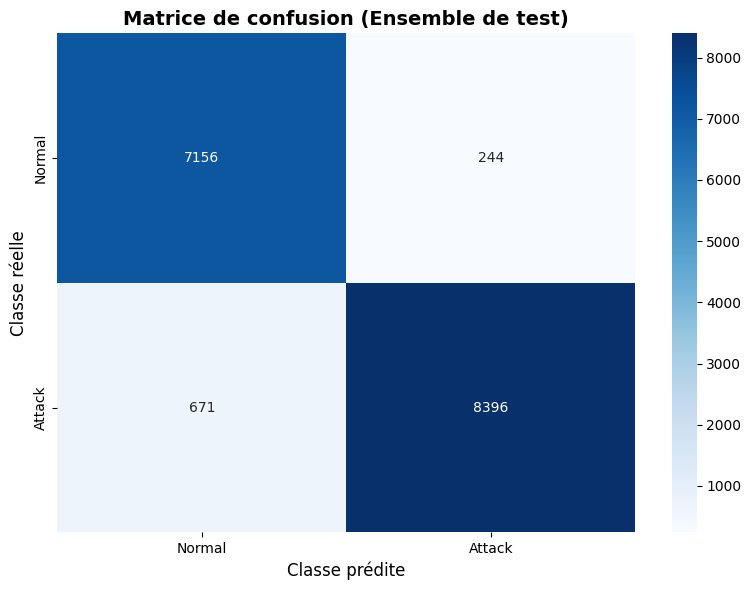

In [12]:

if __name__ == "__main__":
    # Point d'entrée du script
    print("=" * 80)
    print("Pipeline d'analyse et d'entraînement KNN pour la détection d'intrusion réseau")
    print("=" * 80)
    
    # Vérifier si le fichier de données existe
    data_path = "UNSW_NB15_training-set.csv"
    if not os.path.exists(data_path):
        print(f"⚠️ Le fichier {data_path} n'existe pas. Veuillez spécifier le chemin correct.")
        data_path = input("Chemin du fichier de données: ")
    
    # Exécuter le pipeline principal
    main(data_path=data_path, n_epochs=25)

Pipeline d'analyse et d'entraînement MLP pour la détection d'intrusion réseau
Chargement et prétraitement des données depuis UNSW_NB15_training-set.csv...
Données chargées: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 échantillons (55.06%)
  - Classe 0: 37000 échantillons (44.94%)
Encodage des 3 colonnes catégorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de données:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
Entraînement progressif du MLP sur 25 époques...


Entraînement: 100%|██████████| 25/25 [1:05:59<00:00, 158.39s/it, Train Acc=0.9794, Val Acc=0.9685, Train Size=53515]


✅ Meilleur modèle MLP sauvegardé

Temps total d'exécution: 3963.24 secondes (66.05 minutes)

📊 Résumé des performances:
Accuracy finale sur le test: 0.9653
Precision finale sur le test: 0.9776
Recall final sur le test: 0.9589
F1-Score final sur le test: 0.9682
Meilleurs hyperparamètres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}


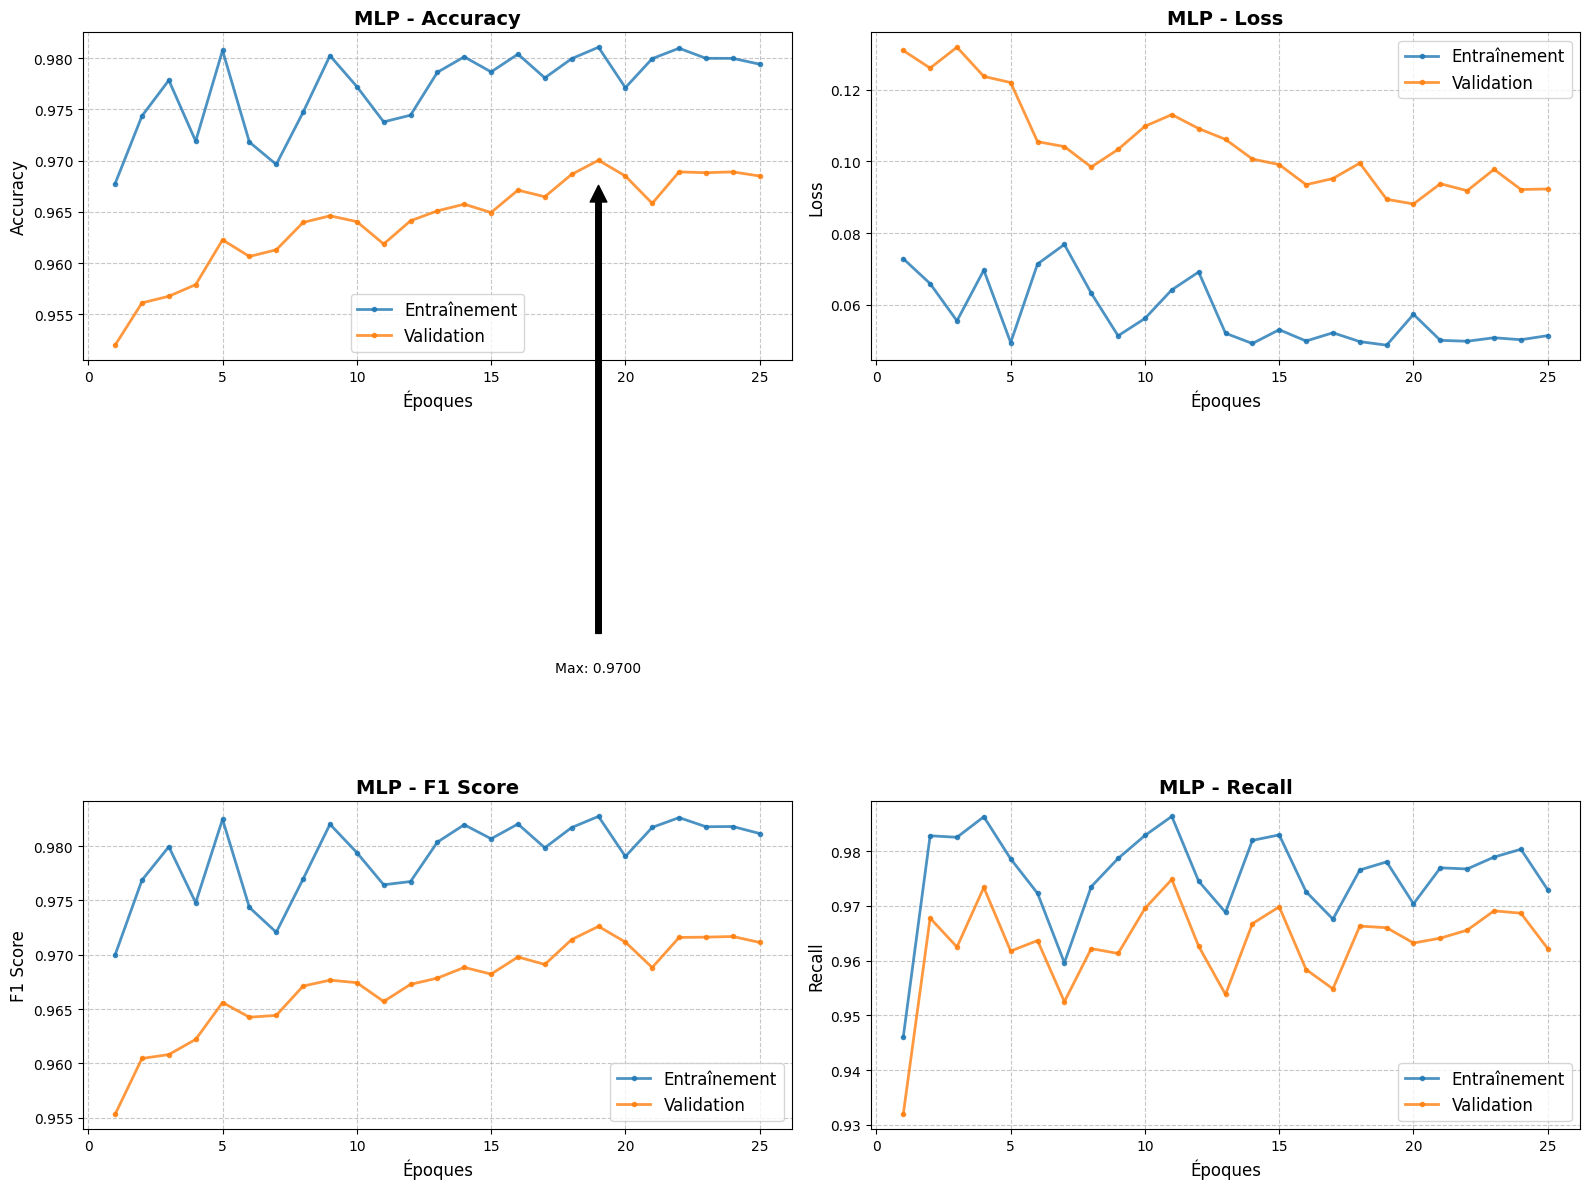

In [ ]:
# Création des dossiers pour les résultats
os.makedirs('figures/mlp', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:

def optimize_mlp_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparamètres du modèle MLP
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        cv: Nombre de plis pour la validation croisée
    Returns:
        Meilleurs hyperparamètres et score
    """
    print(f"Optimisation des hyperparamètres MLP...")
    param_dist = {
        'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }

    mlp = MLPClassifier(max_iter=200, early_stopping=True, random_state=42)
    grid_search = RandomizedSearchCV(
        mlp, param_distributions=param_dist, n_iter=15, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    print(f"Recherche par grille terminée en {search_time:.2f} secondes")

    val_score = accuracy_score(y_val, grid_search.predict(X_val))
    print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")
    print(f"Score de validation croisée: {grid_search.best_score_:.4f}")
    print(f"Score sur l'ensemble de validation: {val_score:.4f}")

    return grid_search.best_params_, val_score



In [ ]:


def train_mlp_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=25):
    """
    Entraîne le modèle MLP de manière progressive en augmentant la taille de l'ensemble d'entraînement
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        X_test: Caractéristiques de test
        y_test: Étiquettes de test
        best_params: Meilleurs hyperparamètres trouvés
        n_epochs: Nombre d'époques d'entraînement
    Returns:
        Historique des métriques et meilleur modèle
    """
    print(f"Entraînement progressif du MLP sur {n_epochs} époques...")

    # Convertir en tableaux NumPy pour éviter les problèmes d'indexation
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(X_val, np.ndarray):
        X_val = np.array(X_val)
    if not isinstance(y_val, np.ndarray):
        y_val = np.array(y_val)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    # Vérifier si l'entraînement est possible
    if len(X_train) == 0 or len(y_train) == 0:
        raise ValueError("Ensembles d'entraînement vides")
    if len(np.unique(y_train)) < 2:
        raise ValueError("L'ensemble d'entraînement doit contenir au moins deux classes différentes")

    # Métriques
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    epoch_train_sizes = []

    # Initialiser le modèle avec les meilleurs paramètres
    model = MLPClassifier(**best_params, random_state=42)

    # Meilleur modèle
    best_model = None
    best_val_acc = 0

    # Valeurs pour l'augmentation progressive de la taille de l'ensemble d'entraînement
    train_ratio_start = 0.2  # Commence avec 20% des données
    train_ratio_end = 1.0    # Termine avec 100% des données

    # Assurer une répartition équilibrée des classes lors de l'échantillonnage
    class_indices = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        class_indices[cls] = np.where(y_train == cls)[0]

    with tqdm(total=n_epochs, desc="Entraînement") as pbar:
        for epoch in range(n_epochs):
            try:
                # Augmentation progressive de la taille de l'entraînement
                train_ratio = train_ratio_start + (train_ratio_end - train_ratio_start) * (epoch / max(1, n_epochs-1))
                indices = []
                for cls in unique_classes:
                    n_samples = int(len(class_indices[cls]) * train_ratio)
                    cls_sample = np.random.choice(class_indices[cls], n_samples, replace=False)
                    indices.extend(cls_sample)
                np.random.shuffle(indices)
                train_size = len(indices)
                epoch_train_sizes.append(train_size)
                # Extraire les données d'entraînement pour cette époque
                X_epoch = X_train[indices]
                y_epoch = y_train[indices]

                # Créer et entraîner le modèle avec les meilleurs hyperparamètres
                model.fit(X_epoch, y_epoch)

                # Évaluations
                train_pred = model.predict(X_epoch)
                val_pred = model.predict(X_val)

                train_accuracies.append(accuracy_score(y_epoch, train_pred))
                val_accuracies.append(accuracy_score(y_val, val_pred))
                train_precisions.append(precision_score(y_epoch, train_pred, zero_division=0))
                val_precisions.append(precision_score(y_val, val_pred, zero_division=0))
                train_recalls.append(recall_score(y_epoch, train_pred, zero_division=0))
                val_recalls.append(recall_score(y_val, val_pred, zero_division=0))
                train_f1s.append(f1_score(y_epoch, train_pred, zero_division=0))
                val_f1s.append(f1_score(y_val, val_pred, zero_division=0))

                # Calcul des pertes (log loss) si predict_proba est disponible
                if hasattr(model, 'predict_proba'):
                    try:
                        train_probs = model.predict_proba(X_epoch)
                        val_probs = model.predict_proba(X_val)
                        # Vérifier la validité des probabilités
                        if not np.any(np.isnan(train_probs)) and not np.any(np.isnan(val_probs)):
                            train_loss = log_loss(y_epoch, train_probs)
                            val_loss = log_loss(y_val, val_probs)
                        else:
                            train_loss = -np.log(max(0.001, train_accuracies[-1]))
                            val_loss = -np.log(max(0.001, val_accuracies[-1]))
                    except Exception:
                        # En cas d'erreur, utiliser une approximation
                        train_loss = -np.log(max(0.001, train_accuracies[-1]))
                        val_loss = -np.log(max(0.001, val_accuracies[-1]))
                else:
                    # Si predict_proba n'est pas disponible, simuler une relation inverse avec l'accuracy
                    train_loss = -np.log(max(0.001, train_accuracies[-1]))
                    val_loss = -np.log(max(0.001, val_accuracies[-1]))

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                pbar.update(1)
                pbar.set_postfix({
                    'Train Acc': f'{train_accuracies[-1]:.4f}',
                    'Val Acc': f'{val_accuracies[-1]:.4f}',
                    'Train Size': train_size
                })

                # Suivre le meilleur modèle
                if val_accuracies[-1] > best_val_acc:
                    best_val_acc = val_accuracies[-1]
                    best_model = model

            except Exception as e:
                print(f"Erreur à l'époque {epoch+1}: {str(e)}")
                continue

    # Si aucun modèle valide n'a été trouvé, utiliser un modèle par défaut
    if best_model is None:
        print("Aucun modèle valide trouvé pendant l'entraînement. Création d'un modèle par défaut.")
        best_model = MLPClassifier(**best_params, random_state=42)
        best_model.fit(X_train, y_train)

     
    try:
        plot_training_metrics(train_accuracies, val_accuracies, train_losses, val_losses, 
                             train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
                             algorithm_name="MLP", output_dir="figures/mlp")
    except Exception as e:
        print(f"Erreur lors de la création des graphiques: {str(e)}")
    # Évaluation finale du meilleur modèle sur l'ensemble de test
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, test_pred)


    # Sauvegarder
    joblib.dump(best_model, "models/mlp_best.pkl")
    print("✅ Meilleur modèle MLP sauvegardé")

    return {
        'model': best_model,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': conf_matrix
    }



In [ ]:
def main():
    data_path = "UNSW_NB15_training-set.csv"
    print("=" * 80)
    print("Pipeline d'analyse et d'entraînement MLP pour la détection d'intrusion réseau")
    print("=" * 80)

    start_time = time.time()

    X_train, X_val, X_test, y_train, y_val, y_test, scaler, encoders = load_and_preprocess_data(data_path)
    joblib.dump(scaler, "models/scaler_mlp.pkl")
    joblib.dump(encoders, "models/label_encoders_mlp.pkl")

    # Optimiser les hyperparamètres
    # best_params, val_score = optimize_mlp_hyperparameters(X_train, y_train, X_val, y_val)
    best_params={'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}
    # Tracer la courbe d'apprentissage pour évaluer l'impact de la taille de l'ensemble d'entraînement
    # model = MLPClassifier(**best_params)
    # plot_learning_curve(model, X_train, y_train)
    # Entraînement progressif
    results = train_mlp_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=25)

    elapsed_time = time.time() - start_time
    print(f"\nTemps total d'exécution: {elapsed_time:.2f} secondes ({elapsed_time / 60:.2f} minutes)")
    print("\n📊 Résumé des performances:")
    print(f"Accuracy finale sur le test: {results['test_accuracy']:.4f}")
    print(f"Precision finale sur le test: {results['test_precision']:.4f}")
    print(f"Recall final sur le test: {results['test_recall']:.4f}")
    print(f"F1-Score final sur le test: {results['test_f1']:.4f}")
    print(f"Meilleurs hyperparamètres: {best_params}")


if __name__ == "__main__":
    main()

In [ ]:
    # Meilleurs hyperparamètres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}

Pipeline d'analyse et d'entraînement XGBoost pour la détection d'intrusion réseau
Chargement et prétraitement des données depuis UNSW_NB15_training-set.csv...
Données chargées: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 échantillons (55.06%)
  - Classe 0: 37000 échantillons (44.94%)
Encodage des 3 colonnes catégorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de données:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
Optimisation des hyperparamètres XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Recherche par grille terminée en 30.87 secondes
Meilleurs hyperparamètres: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, '

Entraînement: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it, Train Acc=0.9935, Val Acc=0.9823, Train Size=53515]


✅ Métriques d'entraînement enregistrées dans figures/xgb\xgboost_accuracy.png
✅ Métriques d'entraînement enregistrées dans figures/xgb\xgboost_loss.png
✅ Métriques d'entraînement enregistrées dans figures/xgb\xgboost_f1_score.png
✅ Métriques d'entraînement enregistrées dans figures/xgb\xgboost_recall.png
✅ Meilleur modèle XGBoost sauvegardé

Temps total d'exécution: 93.31 secondes (1.56 minutes)

📊 Résumé des performances:
Accuracy finale sur le test: 0.9786
Precision finale sur le test: 0.9866
Recall final sur le test: 0.9744
F1-Score final sur le test: 0.9805
Meilleurs hyperparamètres: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
🔍 Analyse de la matrice de confusion:
 - Vrais Négatifs (TN): 7280 (44.21%)
 - Faux Positifs (FP): 120 (0.73%)
 - Faux Négatifs (FN): 232 (1.41%)
 - Vrais Positifs (TP): 8835 (53.65%)
 - Taux de faux positifs: 1.62%
 - Taux de faux négatifs: 2.56%


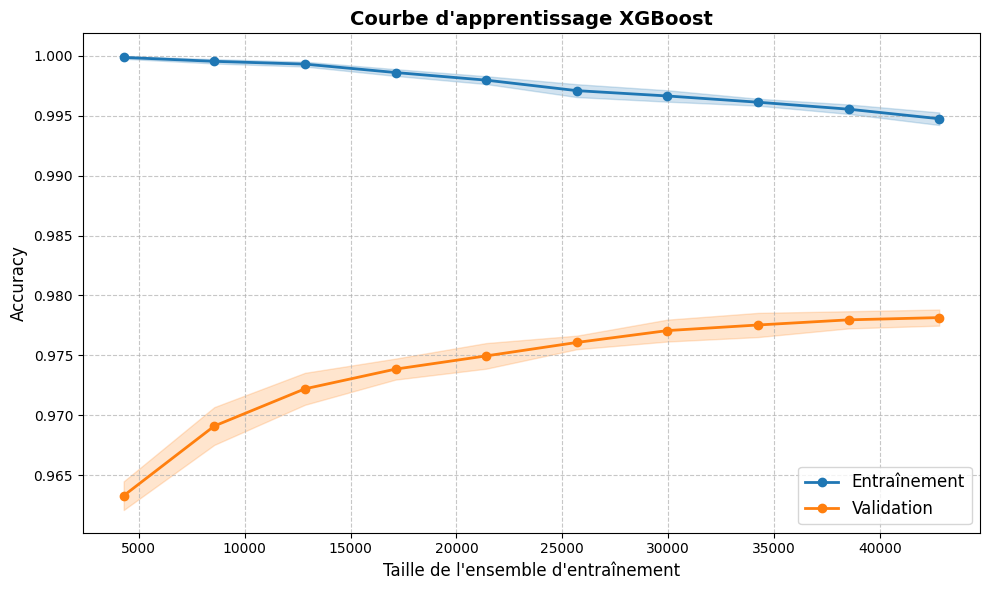

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.exceptions import ConvergenceWarning
import time
from tqdm import tqdm
import warnings

# Supprimer les avertissements non nécessaires
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Création des dossiers pour les résultats
os.makedirs('figures/xgb', exist_ok=True)
os.makedirs('models', exist_ok=True)


def optimize_xgb_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparamètres du modèle XGBoost
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        cv: Nombre de plis pour la validation croisée
    Returns:
        Meilleurs hyperparamètres et score
    """
    print(f"Optimisation des hyperparamètres XGBoost...")
    param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.2],
        'reg_lambda': [1, 1.5, 2]
    }

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    grid_search = RandomizedSearchCV(
        xgb, param_distributions=param_dist, n_iter=15, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    print(f"Recherche par grille terminée en {search_time:.2f} secondes")

    val_score = accuracy_score(y_val, grid_search.predict(X_val))
    print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")
    print(f"Score de validation croisée: {grid_search.best_score_:.4f}")
    print(f"Score sur l'ensemble de validation: {val_score:.4f}")

    return grid_search.best_params_, val_score


def train_xgb_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=25):
    """
    Entraîne le modèle XGBoost de manière progressive en augmentant la taille de l'ensemble d'entraînement
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        X_test: Caractéristiques de test
        y_test: Étiquettes de test
        best_params: Meilleurs hyperparamètres trouvés
        n_epochs: Nombre d'époques d'entraînement
    Returns:
        Historique des métriques et meilleur modèle
    """
    print(f"Entraînement progressif du XGBoost sur {n_epochs} époques...")

    # Métriques
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    epoch_train_sizes = []
     # Convertir en tableaux NumPy pour éviter les problèmes d'indexation
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(X_val, np.ndarray):
        X_val = np.array(X_val)
    if not isinstance(y_val, np.ndarray):
        y_val = np.array(y_val)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    # Initialiser le modèle avec les meilleurs paramètres
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Meilleur modèle
    best_model = None
    best_val_acc = 0

    # Valeurs pour l'augmentation progressive de la taille de l'ensemble d'entraînement
    train_ratio_start = 0.2  # Commence avec 20% des données
    train_ratio_end = 1.0    # Termine avec 100% des données

    # Assurer une répartition équilibrée des classes lors de l'échantillonnage
    class_indices = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        class_indices[cls] = np.where(y_train == cls)[0]

    with tqdm(total=n_epochs, desc="Entraînement") as pbar:
        for epoch in range(n_epochs):
            try:
                # Augmentation progressive de la taille de l'entraînement
                train_ratio = train_ratio_start + (train_ratio_end - train_ratio_start) * (epoch / max(1, n_epochs-1))
                indices = []
                for cls in unique_classes:
                    n_samples = int(len(class_indices[cls]) * train_ratio)
                    cls_sample = np.random.choice(class_indices[cls], n_samples, replace=False)
                    indices.extend(cls_sample)
                np.random.shuffle(indices)
                train_size = len(indices)
                epoch_train_sizes.append(train_size)
                # Extraire les données d'entraînement pour cette époque
                X_epoch = X_train[indices]
                y_epoch = y_train[indices]

                # Créer et entraîner le modèle avec les meilleurs hyperparamètres
                model.fit(X_epoch, y_epoch)

                # Évaluations
                train_pred = model.predict(X_epoch)
                val_pred = model.predict(X_val)

                train_accuracies.append(accuracy_score(y_epoch, train_pred))
                val_accuracies.append(accuracy_score(y_val, val_pred))
                train_precisions.append(precision_score(y_epoch, train_pred, zero_division=0))
                val_precisions.append(precision_score(y_val, val_pred, zero_division=0))
                train_recalls.append(recall_score(y_epoch, train_pred, zero_division=0))
                val_recalls.append(recall_score(y_val, val_pred, zero_division=0))
                train_f1s.append(f1_score(y_epoch, train_pred, zero_division=0))
                val_f1s.append(f1_score(y_val, val_pred, zero_division=0))

                # Calcul des pertes (log loss) si predict_proba est disponible
                if hasattr(model, 'predict_proba'):
                    try:
                        train_probs = model.predict_proba(X_epoch)
                        val_probs = model.predict_proba(X_val)
                        # Vérifier la validité des probabilités
                        if not np.any(np.isnan(train_probs)) and not np.any(np.isnan(val_probs)):
                            train_loss = log_loss(y_epoch, train_probs)
                            val_loss = log_loss(y_val, val_probs)
                        else:
                            train_loss = -np.log(max(0.001, train_accuracies[-1]))
                            val_loss = -np.log(max(0.001, val_accuracies[-1]))
                    except Exception:
                        # En cas d'erreur, utiliser une approximation
                        train_loss = -np.log(max(0.001, train_accuracies[-1]))
                        val_loss = -np.log(max(0.001, val_accuracies[-1]))
                else:
                    # Si predict_proba n'est pas disponible, simuler une relation inverse avec l'accuracy
                    train_loss = -np.log(max(0.001, train_accuracies[-1]))
                    val_loss = -np.log(max(0.001, val_accuracies[-1]))

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                pbar.update(1)
                pbar.set_postfix({
                    'Train Acc': f'{train_accuracies[-1]:.4f}',
                    'Val Acc': f'{val_accuracies[-1]:.4f}',
                    'Train Size': train_size
                })

                # Suivre le meilleur modèle
                if val_accuracies[-1] > best_val_acc:
                    best_val_acc = val_accuracies[-1]
                    best_model = model

            except Exception as e:
                print(f"Erreur à l'époque {epoch+1}: {str(e)}")
                continue

    # Si aucun modèle valide n'a été trouvé, utiliser un modèle par défaut
    if best_model is None:
        print("Aucun modèle valide trouvé pendant l'entraînement. Création d'un modèle par défaut.")
        best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        best_model.fit(X_train, y_train)

    try:
        plot_training_metrics(
            train_accuracies, val_accuracies, train_losses, val_losses, 
            train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
            algorithm_name="XGBoost", output_dir="figures/xgb"
        )
    except Exception as e:
        print(f"Erreur lors de la création des graphiques: {str(e)}")

    # Évaluation finale du meilleur modèle sur l'ensemble de test
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, test_pred)

    # Sauvegarder
    joblib.dump(best_model, "models/xgb_best.pkl")
    print("✅ Meilleur modèle XGBoost sauvegardé")

    return {
        'model': best_model,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': conf_matrix
    }


def plot_training_size(epoch_train_sizes, n_epochs):
    """
    Trace la progression de la taille de l'ensemble d'entraînement
    Args:
        epoch_train_sizes: Liste des tailles d'entraînement à chaque époque
        n_epochs: Nombre d'époques
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs+1), epoch_train_sizes, '-o', linewidth=2, markersize=4, color='#2ca02c')
    plt.title('Progression de la taille de l\'ensemble d\'entraînement', fontsize=14, fontweight='bold')
    plt.xlabel('Époque', fontsize=12)
    plt.ylabel('Nombre d\'échantillons', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('figures/xgb/xgb_training_size.png', dpi=300)
    plt.close()


def plot_confusion_matrix(conf_matrix):
    """
    Trace la matrice de confusion
    Args:
        conf_matrix: Matrice de confusion
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title('Matrice de confusion (Ensemble de test)', fontsize=14, fontweight='bold')
    plt.xlabel('Classe prédite', fontsize=12)
    plt.ylabel('Classe réelle', fontsize=12)
    plt.tight_layout()
    plt.savefig('figures/xgb/xgb_confusion_matrix.png', dpi=300)
    plt.close()


def main(data_path="UNSW_NB15_training-set.csv", test_size=0.2, val_size=0.15, n_epochs=25, random_state=42):
    """
    Fonction principale qui exécute tout le pipeline
    """
    print("=" * 80)
    print("Pipeline d'analyse et d'entraînement XGBoost pour la détection d'intrusion réseau")
    print("=" * 80)

    start_time = time.time()

    X_train, X_val, X_test, y_train, y_val, y_test, scaler, encoders = load_and_preprocess_data(
        filepath=data_path, test_size=test_size, val_size=val_size, random_state=random_state
    )
    joblib.dump(scaler, "models/scaler_xgb.pkl")
    joblib.dump(encoders, "models/label_encoders_xgb.pkl")

    # Optimiser les hyperparamètres
    best_params, val_score = optimize_xgb_hyperparameters(X_train, y_train, X_val, y_val, cv=3)
    # Tracer la courbe d'apprentissage pour évaluer l'impact de la taille de l'ensemble d'entraînement
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    plot_learning_curve(model, X_train, y_train)
    # Entraînement progressif
    results = train_xgb_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=n_epochs)

    elapsed_time = time.time() - start_time
    print(f"\nTemps total d'exécution: {elapsed_time:.2f} secondes ({elapsed_time / 60:.2f} minutes)")
    print("\n📊 Résumé des performances:")
    print(f"Accuracy finale sur le test: {results['test_accuracy']:.4f}")
    print(f"Precision finale sur le test: {results['test_precision']:.4f}")
    print(f"Recall final sur le test: {results['test_recall']:.4f}")
    print(f"F1-Score final sur le test: {results['test_f1']:.4f}")
    print(f"Meilleurs hyperparamètres: {best_params}")

    # Évaluation finale du modèle
    print("🔍 Analyse de la matrice de confusion:")
    conf_matrix = results['confusion_matrix']
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    print(f" - Vrais Négatifs (TN): {tn} ({tn/total*100:.2f}%)")
    print(f" - Faux Positifs (FP): {fp} ({fp/total*100:.2f}%)")
    print(f" - Faux Négatifs (FN): {fn} ({fn/total*100:.2f}%)")
    print(f" - Vrais Positifs (TP): {tp} ({tp/total*100:.2f}%)")
    print(f" - Taux de faux positifs: {fp/(fp+tn)*100:.2f}%")
    print(f" - Taux de faux négatifs: {fn/(fn+tp)*100:.2f}%")


    # Tracer la matrice de confusion pour le meilleur modèle
    plot_confusion_matrix(conf_matrix)


if __name__ == "__main__":
    main()